# EDA for UNSW-NB15 Data Set

I've taken two datasets of point anomaly data down from [the dataset hosting] website(https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/). The first contains pre-partioned CSV files for a training and test set of data. The rows in these files have eliminated columns pertaining to specific IP address and port numbers, as well as eliminated two columns that indicated when the connectioned was opened and closed. I did all of my EDA for that dataset using only the training data CSV file. This training set contains just over 175k observations and is housed in the generically named dataframe `data`.

The second dataset consists of four larger CSV files that contain slightly less polished data. There are some missing values that had to be explained and accounted for (as can be seen in the more involved transformations). These files also include IP addresses and ports used for the observation, as well as date time values. There is also one feature, `rate`, in the pre-partitioned set that is not in these files. Because there are more than 2.5M observations across these four CSV files, I've put them together and used them for my analysis. This dataset is housed in a dataframe referred to as `all_data` in this notebook.

In [42]:
# Data Containers
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Data Processing Imports
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

# Pipeline Testing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score

In [4]:
def reduce_column(s, to_keep):
    '''
    Reduces the string values found in a column
    to the values provided in the list 'to_keep'.
    ---
    Input:
        s: string
        to_keep: list of strings
    Returns:
        string, s if s should be kept, else 'other'
    '''
    s = s.lower().strip()
    if s not in to_keep:
        return 'other'
    else:
        return s

# EDA For Provided Training Set

In [6]:
# Read in and preview training set csv data
data = pd.read_csv('./data/UNSW_NB15_train_set.csv', header=0, index_col=0)
data.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
id,,,,,,,,,,,,,,,,,,,,,
1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,...,1,1,0,0,0,1,1,0,Normal,0
2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,...,1,2,0,0,0,1,6,0,Normal,0
3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,...,1,3,0,0,0,2,6,0,Normal,0
4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,...,1,3,1,1,0,2,1,0,Normal,0
5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,...,1,40,0,0,0,2,39,0,Normal,0


In [7]:
# Look at available columns. Descriptions can be found in the file UNSW-NB15_features.csv
data.columns

Index(['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')

Note that IP address and port numbers are not included in the data set, and that we've used the id column as an index. Pre-dropped columns:
* id
* srcip
* sport
* dstip
* dsport  

This brings us to 42 data columns that we'll have to use as features and 2 columns to use as target values, depending on whether I want to tackle a binary or multiclass classification problem.

In [8]:
# Total number of observations
n_obs = data.shape[0]
print(n_obs)

175341


In [9]:
# Check the amount of invalid (NaN) data
data.isnull().sum().sum()

0

In [10]:
# Get the types of attacks available in the dataset
data.attack_cat.unique()

array(['Normal', 'Backdoor', 'Analysis', 'Fuzzers', 'Shellcode',
       'Reconnaissance', 'Exploits', 'DoS', 'Worms', 'Generic'],
      dtype=object)

The pre-provided datasets are actually more suited to classification approaches rather than anomaly detection. From below, there are actually more attack instances than normal data in the provided training set.

In [11]:
# Determine number of attack and normal data instances in the dataset
mask = data.label == 1
print("No. of attacks:", data[mask].label.size)
print("No. of normal: ", data[~mask].label.size)

No. of attacks: 119341
No. of normal:  56000


Using the correlation matrix to have a quick look at which features correlate with an attack label.

In [12]:
data.corr()['label'].sort_values(ascending=False)

label                1.000000
sttl                 0.692741
ct_state_ttl         0.577704
ct_dst_sport_ltm     0.357213
rate                 0.337979
ct_src_dport_ltm     0.305579
ct_dst_src_ltm       0.303855
ct_src_ltm           0.238225
ct_dst_ltm           0.229887
ct_srv_src           0.229044
ct_srv_dst           0.228046
sload                0.182870
ackdat               0.097364
dttl                 0.095049
tcprtt               0.081584
synack               0.058299
dur                  0.036175
sbytes               0.018576
ct_flw_http_mthd     0.015800
trans_depth          0.010801
sloss               -0.000640
sjit                -0.007069
smean               -0.010798
ct_ftp_cmd          -0.011055
is_ftp_login        -0.011055
response_body_len   -0.021361
dinpkt              -0.022887
spkts               -0.052178
djit                -0.060870
dbytes              -0.076871
dloss               -0.094685
dpkts               -0.118591
sinpkt              -0.176110
is_sm_ips_

In [13]:
# Determining unique values for each row.
# This dataset contains a mixture of categorical, continuous, and ordinal features that I'll have to examine.
for col in data.columns:
    print(col, len(data[col].unique()))

dur 74039
proto 133
service 13
state 9
spkts 480
dpkts 443
sbytes 7214
dbytes 6660
rate 76991
sttl 11
dttl 6
sload 80885
dload 77474
sloss 409
dloss 370
sinpkt 76161
dinpkt 74245
sjit 77532
djit 76831
swin 13
stcpb 75265
dtcpb 75089
dwin 7
tcprtt 43319
synack 40142
ackdat 37708
smean 1357
dmean 1328
trans_depth 11
response_body_len 2386
ct_srv_src 52
ct_state_ttl 5
ct_dst_ltm 50
ct_src_dport_ltm 47
ct_dst_sport_ltm 32
ct_dst_src_ltm 54
is_ftp_login 4
ct_ftp_cmd 4
ct_flw_http_mthd 11
ct_src_ltm 50
ct_srv_dst 52
is_sm_ips_ports 2
attack_cat 10
label 2


In [14]:
# Columns will need to be inspected to confirm that values correspond to the correct range.
# For example, the feature `is_ftp_login` should be binary but has values > 1
data.is_ftp_login.value_counts()

0    172774
1      2545
4        16
2         6
Name: is_ftp_login, dtype: int64

The categorical features I'm concerned with below are `proto`, `state`, and `service`. They govern the type of connection and requests for a given observation. I'm planning on doing some initial modeling with only the numeric features as a baseline, but these context features may be useful for identifying certain connection types that are characteristic of attacks.

In [25]:
# There are 133 unique protocols in the dataset.
# May be worth reducing this column to 3-5 values for more concise encoding (without adding 132 features)
data.proto.value_counts().head(10)

tcp       79946
udp       63283
unas      12084
arp        2859
ospf       2595
sctp       1150
any         300
gre         225
mobile      201
ipv6        201
Name: proto, dtype: int64

In [16]:
# Inspect unique values for 'state' feature
data.state.value_counts()

INT    82275
FIN    77825
CON    13152
REQ     1991
RST       83
ECO       12
no         1
PAR        1
URN        1
Name: state, dtype: int64

In [18]:
# Inspect unique values for 'service' feature
data.service.value_counts()

-           94168
dns         47294
http        18724
smtp         5058
ftp-data     3995
ftp          3428
ssh          1302
pop3         1105
dhcp           94
snmp           80
ssl            56
irc            25
radius         12
Name: service, dtype: int64

In [19]:
# Source Time To Live (sttl) is an example of one of the ordinal features.
# The greater the value, the more routers the information can pass through.
data.sttl.unique()

array([252,  62, 254,   0,   1,  31,  63,  64,  60,  29, 255])

# Full Dataset EDA
Currently, the test and training set partitions are very balanced. I'm taking a look at the full dataset to explore the actual class balance and get a feel for the features and what they mean. Once preliminary feature engineering and model selection has been finished, I think that the model should then be trained on the full dataset. Given my computer's hardware and the time frame for accomplishing my project, locally tuning models using even 80% of the full dataset is not recommended.

This dataset is created by reading in 4 large (100+ mb) CSV files and agglomerating them in a single dataframe. Through some preliminary work I've identified discrepancies for a few features where 0 values were sometimes left blank. Those discrepancies are reflected in the column transformations in the blocks below.  

I've also reduced the categorical features into one of either 3-5 values depending on the column. Many of the values are rare enough without showing any correlation with the attack class that I've grouped many of them under "other." This did occur to me here, however I have to credit [this paper](https://pdfs.semanticscholar.org/a403/951e44231dc55f752f61e10b01e4fb9a1189.pdf) for demonstrating this categorical streamlining in practice.  

The following block of code is the inspiration for the `load_agg_data` and `load_agg_Xy` function in the `data_prep.py` file that allow me to quickly prepare the dataset for modeling. 

In [20]:
dfs = []
for i in range(1,5):
    path = './data/UNSW-NB15_{}.csv'
    dfs.append(pd.read_csv(path.format(i), header = None))
all_data = pd.concat(dfs).reset_index(drop=True)
## Grab feature names from related csv of feature descriptions
all_data.columns = pd.read_csv('./data/UNSW-NB15_features.csv').Name.apply(lambda x: x.lower())


## Column cleaning steps: some of the CSV's leave the point blank for zero values.
## This results in Pandas loading in NaN values in columns where it otherwise expects numeric values. 
# Fill all NaN attack categories w/ value: 'normal'
all_data['attack_cat'] = all_data.attack_cat.fillna(value='normal').apply(lambda x: x.strip().lower())
# Replace blank spaces with zero
all_data['ct_ftp_cmd'] = all_data.ct_ftp_cmd.replace(to_replace=' ', value=0).astype(int)
# Replace NaN with zero
all_data['ct_flw_http_mthd'] = all_data.ct_flw_http_mthd.fillna(value=0)
# Replace NaN with zero and all values > 0 with 1
all_data['is_ftp_login'] = (all_data.is_ftp_login.fillna(value=0) >0).astype(int)

## Reduce categorical features into smaller sets:
## Ex: 135 unique values in `proto` become "tcp", "udp", "arp", "unas", and "other"
transformations = {
    'proto':['tcp', 'udp', 'arp', 'unas'],
    'state':['fin', 'con', 'int'],
    'service':['-', 'dns']
}
for col, keepers in transformations.items():
    all_data[col] = all_data[col].apply(reduce_column, args=(keepers,))

all_data.shape

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(2540047, 49)

In [21]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2540047 entries, 0 to 2540046
Data columns (total 49 columns):
srcip               object
sport               object
dstip               object
dsport              object
proto               object
state               object
dur                 float64
sbytes              int64
dbytes              int64
sttl                int64
dttl                int64
sloss               int64
dloss               int64
service             object
sload               float64
dload               float64
spkts               int64
dpkts               int64
swin                int64
dwin                int64
stcpb               int64
dtcpb               int64
smeansz             int64
dmeansz             int64
trans_depth         int64
res_bdy_len         int64
sjit                float64
djit                float64
stime               int64
ltime               int64
sintpkt             float64
dintpkt             float64
tcprtt              float64
synack

In [22]:
# Fraction of connections that are attacks: roughly 12.6%
np.sum(all_data.label == 1)/all_data.shape[0]

0.12648702957071267

In [23]:
# Confirm missing data has been addressed in processes above
all_data.isnull().sum().sum()

0

In [24]:
# Compare columns in larger csv files w/ those in partitioned training and test sets
full_cols = set(all_data.columns)
train_cols = set(data.columns)

# Number of columns the two datasets have in common:
print('No. of common columns:', len(train_cols.intersection(full_cols)))

#Columns in training data not in raw CSV's
print(train_cols - full_cols)

# Columns in raw CSV's not in training data
print(full_cols - train_cols)

No. of common columns: 38
{'response_body_len', 'rate', 'dinpkt', 'dmean', 'smean', 'sinpkt'}
{'dsport', 'srcip', 'dmeansz', 'dintpkt', 'ltime', 'stime', 'sintpkt', 'sport', 'smeansz', 'dstip', 'res_bdy_len'}


In [26]:
# Correlation for features in the full dataset.
# I'm seeing similar features to the limited dataset correlation matrix, but the trend is stronger here.
all_data.corr()['label'].sort_values(ascending=False)

Name
label               1.000000
sttl                0.904393
ct_state_ttl        0.873694
ct_dst_src_ltm      0.439916
ct_dst_sport_ltm    0.419056
ct_src_dport_ltm    0.396749
ct_srv_dst          0.386509
ct_srv_src          0.383007
ct_src_ltm          0.343246
ct_dst_ltm          0.339464
ltime               0.275660
stime               0.275660
sload               0.192278
ackdat              0.143443
tcprtt              0.143109
dttl                0.134947
synack              0.122253
sjit                0.020959
sbytes              0.010180
dur                 0.001959
dintpkt            -0.010632
is_sm_ips_ports    -0.015477
sintpkt            -0.019034
ct_flw_http_mthd   -0.026561
res_bdy_len        -0.027339
trans_depth        -0.029041
ct_ftp_cmd         -0.029654
is_ftp_login       -0.032642
sloss              -0.043272
djit               -0.054420
smeansz            -0.065363
dbytes             -0.075543
dloss              -0.095855
dpkts              -0.115947
spkts    

The block below is a collection of functions I used to inspect the columns to get a feel for each feature's range of unique values, distribution, and their tendency to be associated with attacks or not.

In [27]:
## Column inspection blocks used to inspect the values in each row (uncomment as needed):

## Determine the distribution and value ranges for a given column
#col = 'ackdat'
#all_data[col].describe(), all_data[col].value_counts(dropna=False), all_data[col].hist(bins=20)

## Determine how specific values in a column correspond to attack or normal data labels
#all_data[all_data.sttl == 254].label.value_counts(sort=False)

## Convert the above call into a ratio
#counts = all_data[all_data.is_sm_ips_ports == 0].label.value_counts(sort=False)
#counts[1]/np.sum(counts) #attack ratio: standard for whole dataset is 0.126...

## What is the 'Rate' column?
The column comparisons between the two datasets reveal differences in column names due to spelling or dropping of IP, port, and connection time data. They also identify a column `rate` in the provided training set that is not in the raw CSV files.

In the blocks below I take the first row in the training set and find it again in the full dataset to see if `rate` corresponds to anything in that dataset. It doesn't appear to do so, but the feature should be scaled along with the rest of the numeric features. More research on this dataset online may yeild the answer.

In [28]:
# Get first observation in training set
data.head(1)

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
id,,,,,,,,,,,,,,,,,,,,,
1,0.121478,tcp,-,FIN,6,4,258,172,74.08749,252,...,1,1,0,0,0,1,1,0,Normal,0


In [29]:
## Look at that observation as seen in the raw CSV files.
## Can we identify rate as a combination of existing features?
mask = (all_data.spkts == 6) & (all_data.dbytes==172) & (all_data.dur == 0.121478)
all_data[mask]

Name,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,label
1087203,149.171.126.14,179,175.45.176.3,33159,tcp,fin,0.121478,258,172,252,...,0,1,1,1,1,1,1,1,normal,0


# One - Hot Encoding
Categorical features should make it into the model, but first should be narrowed to a select few values. For example, the variable `proto` identifies the connection protocol used. There are 135 different protocols in the dataset of 2.5M connections, but only 6 of the protocols occur more than a thousand times. Of those top 6, `tcp` accounts for just under 1.5M connections (~59%) and `udp` for another 990k (~39%).  

Going off the heuristic that more features leads to more model complexity and associated over-fitting challenges, it would be unwise to blindly one-hot-encode this and all other categorical features. If I were training a neural network it might be acceptable, but that's not the case for this project.  

I performed some EDA where I looked at what proprotion of observations with a given categorical feature were anomalies or normal data. From those observations, I think I can reduce the categories for most categorical variables down to 3 or 4 values. For example, `proto` can be reduced to `tcp`, `udp`, `unas`, `arp`, and `other`. Other papers have proposed even fewer: `tcp`, `udp`, and `other`. I've opted to keep `unas` and `arp` because they are almost entirely all attack observations and I want to have that powerful of a contextual feature available.

**Note that features are arranged in alphabetical order after being encoded.** Using the above example, the output of a OHE would be an array with five columns, each column corresponding to `arp`, `other`, `tcp`, `udp`, `unas`, respectively.

In [32]:
# Create encoder instance that returns an array. Visualize effect using Pandas DataFrame
ohe = OneHotEncoder(sparse=False)

In [33]:
# Test OneHotEncoder on the proto column.
# Will need to get a "leave-one-out" encoder for linear models
test_proto = pd.DataFrame(ohe.fit_transform(pd.DataFrame(all_data.proto)))
test_proto.columns = ohe.get_feature_names()
test_proto.head()

,x0_arp,x0_other,x0_tcp,x0_udp,x0_unas
0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0


# Column-Specific Transformations Experimentation

When data is transformed in the pipeline, the original column is removed and the new data is added to the front row of the existing data structure (array or sparse matrix). The columns are transformed in the order specified in the "columns to transform" parameter in the transformer tuples sent to the ColumnTransformer object. The order in which they occur in the list of transformers also dictates the order in which it appears in the new data structure: the first tuples of transformations are the most to the left in the new structure.

The `remainder` parameter determines whether or not un-transformed columns are retained in the data. Setting it to `"passthrough"` allows me to retain the binary columns and the `label` column and look at the correlation matrix for the transformed data.

Standard scaling is incorporated for all other numeric feature columns after inspections revealed that none of them are normally distributed. Rather, they almost all have a Poisson distribution.

In [34]:
# The columns below, besides 'attack_cat' which acts as an optional label for multiclass, are
# not needed for further modeling after some research online as to what they mean.
droppable_cols = ['srcip', 'sport', 'dstip', 'dsport', 'ltime', 'stime', 'attack_cat']
binary_cols = ['is_sm_ips_ports', 'is_ftp_login']
target_cols = ['label']

In [35]:
# Define the individual steps
ohe_step = ('ohe', OneHotEncoder(sparse=False))
ssc_step = ('std_sclr', StandardScaler())
log_step = ('log10', FunctionTransformer(np.log10))

# Make the step part of a pipeline
ohe_pipe = Pipeline([ohe_step])
ssc_pipe = Pipeline([ssc_step])
log_ssc_pipe = Pipeline([log_step, ssc_step])

# Columns to transform: categorical columns for encoding, numeric feature columns for standardizing
ohe_cols = ['proto', 'state', 'service']
non_ssc_cols = ohe_cols+droppable_cols+binary_cols+target_cols
#ssc_cols = all_data.drop(columns = ohe_cols+droppable_cols+['label']).columns
ssc_cols = [col for col in all_data.columns if col not in non_ssc_cols]

# Transformer input: tuple w/ contents ('name', SomeTransformer(Parameters), columns)
transformer = [
    ('one_hot_encoding', ohe_pipe, ohe_cols),
    ('standard_scaling', ssc_pipe, ssc_cols)
]

In [36]:
# Implementing and testing the column transformer
ct = ColumnTransformer(transformers=transformer, remainder='passthrough')
#ct = ColumnTransformer(transformers=transformer)

In [37]:
# Recreating column labels for one_hot_encoded data
cat_cols = np.concatenate((np.sort(all_data.proto.unique()),
                           np.sort(all_data.state.unique()),
                           np.sort(all_data.service.unique())))

# Combining transformed column labels with non-transformed column labels.
# Order matters here: transformed columns in order, non-transformed features, target column
new_cols =  np.concatenate((cat_cols, ssc_cols, binary_cols, target_cols))

In [38]:
#pd.DataFrame(ct.fit_transform(all_data.drop(columns=['attack_cat']))).head()
new_data = pd.DataFrame(ct.fit_transform(all_data.drop(columns=droppable_cols)))
new_data.columns = new_cols

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [39]:
# Preview changed data
new_data.head()

,arp,other,tcp,udp,unas,con,fin,int,other,-,...,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_sm_ips_ports,is_ftp_login,label
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.572772,-0.183780,-0.666391,-0.475437,-0.429620,-0.419913,-0.519252,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,-0.665051,-0.460981,-0.543872,-0.475437,-0.429620,-0.419913,-0.430429,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.257735,-0.091380,-0.666391,-0.597313,-0.311662,-0.419913,-0.519252,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.295936,0.001020,-0.666391,-0.719189,-0.429620,-0.419913,-0.519252,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.203658,0.001020,-0.666391,-0.719189,-0.429620,-0.419913,-0.519252,0.0,0.0,0.0


In [40]:
# Checking correlations for transformed data to the target column 'label'.
# It's interesting to see that the sttl and ct_state_ttl are still the most
# strongly correlated, but there are a handful of contextual features above 0.
corrs = new_data.corr()
corrs['label'].sort_values(ascending=False)

label               1.000000
sttl                0.904393
ct_state_ttl        0.873694
int                 0.595858
ct_dst_src_ltm      0.439916
ct_dst_sport_ltm    0.419056
ct_src_dport_ltm    0.396749
ct_srv_dst          0.386509
ct_srv_src          0.383007
ct_src_ltm          0.343246
ct_dst_ltm          0.339464
dns                 0.286789
udp                 0.239130
other               0.220946
unas                0.210555
sload               0.192278
ackdat              0.143443
tcprtt              0.143109
dttl                0.134947
synack              0.122253
sjit                0.020959
sbytes              0.010180
dur                 0.001959
other              -0.001075
dintpkt            -0.010632
is_sm_ips_ports    -0.015477
sintpkt            -0.019034
arp                -0.024000
ct_flw_http_mthd   -0.026561
res_bdy_len        -0.027339
trans_depth        -0.029041
ct_ftp_cmd         -0.029654
is_ftp_login       -0.032642
sloss              -0.043272
djit          

# Pipeline Test

The example below uses a random forest classifier (because it's relatively quick to train) and the column transforms above to make predictions on the provided data. I'm running it here to verify that the pipeline can process data without any glaring errors. **I am not using the results below to say anything about model performance or what I consider good practice, only as a test that my pipeline is acting as expected.**

In [45]:
# Create pipeline object with column transformations and model fitting
data_prep = ('data_prep', ColumnTransformer(transformers=transformer, remainder='passthrough'))
rfc_step = ('data_model', RandomForestClassifier())
model = Pipeline([data_prep, rfc_step])

# Fitting model on the available full data set
model.fit(all_data.drop(
    columns=['srcip', 'sport', 'dstip', 'dsport', 'label','attack_cat']),all_data.label)
# Testing that pipeline works with predicting outcomes
roc_auc_score(all_data.label,model.predict(
    all_data.drop(columns=['srcip', 'sport', 'dstip', 'dsport', 'label','attack_cat'])))

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.9989532604757794

Given that this is a first-pass model, the above AUC score smells like over-fitting. I'll deal with those considerations later, for now we've confirmed that the pipeline performs as expected.

In [46]:
# Quick inspection of feature importances
model.named_steps['data_model'].feature_importances_

array([5.15799203e-05, 2.75005577e-03, 1.41660006e-04, 1.16805210e-03,
       1.61308254e-07, 9.18800030e-03, 2.12382732e-04, 3.80819958e-02,
       1.23343140e-03, 4.78938703e-03, 5.11698514e-04, 1.45873411e-03,
       2.60203416e-03, 1.40025045e-01, 4.72754120e-03, 1.24112136e-01,
       2.66586261e-02, 1.62668342e-03, 9.20207699e-04, 7.68324836e-02,
       4.25692424e-03, 1.73322366e-03, 3.82828991e-02, 2.20970769e-03,
       8.02608059e-06, 1.62223924e-03, 1.58841704e-03, 4.78151309e-02,
       2.96349744e-03, 2.38739651e-04, 8.58457492e-04, 1.85809273e-03,
       2.43117767e-03, 1.95452290e-02, 3.71507237e-02, 3.00497820e-03,
       1.49475653e-02, 2.70953449e-02, 3.02032610e-01, 1.64672682e-04,
       1.56910833e-05, 6.52912238e-03, 1.80918991e-02, 1.62444745e-03,
       1.43451558e-03, 2.53952729e-03, 6.50651531e-03, 5.07519388e-03,
       3.93355212e-03, 4.10475425e-03, 3.22953059e-03, 1.56983825e-05])

# Attacks and non-attacks: quick PCA visualization
Below I use PCA to quickly visualize the smaller dataset `data` in 2-D. While this may not be wholly representative of a hyper-plane, it does provide some context as to how the point anomalies relate to the normal data. I'm also curious as to what will come out of this. To prevent larger magnitude features from drowning out variations in ordinal or binary features in the principal components, I'm going to quickly scale everything.

In [52]:
pca = PCA(n_components=2)
data_2d = pca.fit_transform(StandardScaler().fit_transform(
    data.select_dtypes(exclude='object').drop(columns= ['dtcpb', 'stcpb'])))
mask = data.label==1

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


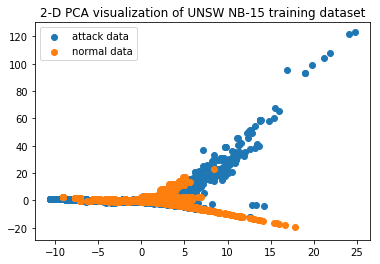

In [55]:
plt.scatter(data_2d[mask,0], data_2d[mask,1], label = 'attack data')
plt.scatter(data_2d[~mask,0], data_2d[~mask,1], label = 'normal data')
plt.title('2-D PCA visualization of UNSW NB-15 training dataset')
plt.legend();

There's some intresting differences emerging from the above visualization. While much of the variance is lost while using only two components, I may be able to look at reducing the feature space down to maybe 8-20 features for computational cost's sake later on in the modeling.

In [56]:
# How much of the variance is captured by each component?
#pca.components_
pca.explained_variance_ratio_

array([0.24166227, 0.10272869])